<!-- HTML file automatically generated from DocOnce source (https://github.com/doconce/doconce/)
doconce format html week10.do.txt --no_mako -->
<!-- dom:TITLE: PHY321: Harmonic oscillations: Time-dependent Forces and Fourier Series -->

# PHY321: Harmonic oscillations: Time-dependent Forces and Fourier Series
**[Morten Hjorth-Jensen](http://mhjgit.github.io/info/doc/web/)**, Department of Physics and Astronomy and Facility for Rare Ion Beams (FRIB), Michigan State University, USA and Department of Physics, University of Oslo, Norway

Date: **Mar 16, 2022**

Copyright 1999-2022, [Morten Hjorth-Jensen](http://mhjgit.github.io/info/doc/web/). Released under CC Attribution-NonCommercial 4.0 license

## Aims and Overarching Motivation

Driven oscillations and resonances with physical examples.

### Monday, March 14

Summary of analytical expressions from February 28-March 4 (see slides at <https://mhjensen.github.io/Physics321/doc/pub/week9/html/week9-reveal.html>. Discussion of resonances and other examples like the mathematical pendulum and other systems.

**Reading suggestion**: Taylor sections 5.6-5.8.

### Wednesday

Examples of oscillations and Fourier analysis applied to harmonic oscillations.

**Reading suggestion**: See lecture notes at <https://mhjensen.github.io/Physics321/doc/pub/week10/html/week10-reveal.html> and Taylor sections 5.6-5.8.

### Friday

Work on homework 6 and discussions of harmonic oscillation examples and systems.

## Numerical Studies of Driven Oscillations

Solving the problem of driven oscillations numerically gives us much
more flexibility to study different types of driving forces. We can
reuse our earlier code by simply adding a driving force. If we stay in
the $x$-direction only this can be easily done by adding a term
$F_{\mathrm{ext}}(x,t)$. Note that we have kept it rather general
here, allowing for both a spatial and a temporal dependence.

Before we dive into the code, we need to briefly remind ourselves
about the equations we started with for the case with damping, namely

$$
m\frac{d^2x}{dt^2} + b\frac{dx}{dt}+kx(t) =0,
$$

with no external force applied to the system.

Let us now for simplicty assume that our external force is given by

$$
F_{\mathrm{ext}}(t) = F_0\cos{(\omega t)},
$$

where $F_0$ is a constant (what is its dimension?) and $\omega$ is the frequency of the applied external driving force.
**Small question:** would you expect energy to be conserved now?

Introducing the external force into our lovely differential equation
and dividing by $m$ and introducing $\omega_0^2=\sqrt{k/m}$ we have

$$
\frac{d^2x}{dt^2} + \frac{b}{m}\frac{dx}{dt}+\omega_0^2x(t) =\frac{F_0}{m}\cos{(\omega t)},
$$

Thereafter we introduce a dimensionless time $\tau = t\omega_0$
and a dimensionless frequency $\tilde{\omega}=\omega/\omega_0$. We have then

$$
\frac{d^2x}{d\tau^2} + \frac{b}{m\omega_0}\frac{dx}{d\tau}+x(\tau) =\frac{F_0}{m\omega_0^2}\cos{(\tilde{\omega}\tau)},
$$

Introducing a new amplitude $\tilde{F} =F_0/(m\omega_0^2)$ (check dimensionality again) we have

$$
\frac{d^2x}{d\tau^2} + \frac{b}{m\omega_0}\frac{dx}{d\tau}+x(\tau) =\tilde{F}\cos{(\tilde{\omega}\tau)}.
$$

Our final step, as we did in the case of various types of damping, is
to define $\gamma = b/(2m\omega_0)$ and rewrite our equations as

$$
\frac{d^2x}{d\tau^2} + 2\gamma\frac{dx}{d\tau}+x(\tau) =\tilde{F}\cos{(\tilde{\omega}\tau)}.
$$

This is the equation we will code below using the Euler-Cromer method.

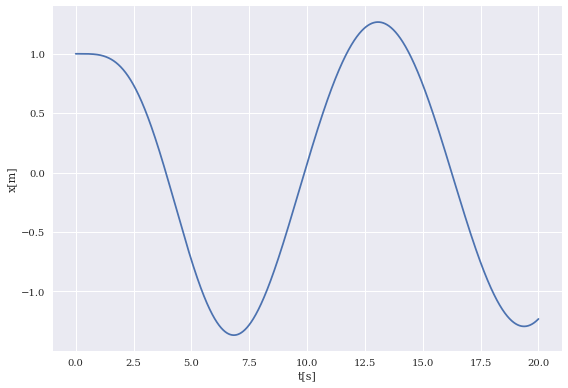

In [1]:
%matplotlib inline


# Common imports
import numpy as np
import pandas as pd
from math import *
import matplotlib.pyplot as plt
import os

# Where to save the figures and data files
PROJECT_ROOT_DIR = "Results"
FIGURE_ID = "Results/FigureFiles"
DATA_ID = "DataFiles/"

if not os.path.exists(PROJECT_ROOT_DIR):
    os.mkdir(PROJECT_ROOT_DIR)

if not os.path.exists(FIGURE_ID):
    os.makedirs(FIGURE_ID)

if not os.path.exists(DATA_ID):
    os.makedirs(DATA_ID)

def image_path(fig_id):
    return os.path.join(FIGURE_ID, fig_id)

def data_path(dat_id):
    return os.path.join(DATA_ID, dat_id)

def save_fig(fig_id):
    plt.savefig(image_path(fig_id) + ".png", format='png')


from pylab import plt, mpl
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'


DeltaT = 0.001
#set up arrays 
tfinal = 20 # in dimensionless time
n = ceil(tfinal/DeltaT)
# set up arrays for t, v, and x
t = np.zeros(n)
v = np.zeros(n)
x = np.zeros(n)
# Initial conditions as one-dimensional arrays of time
x0 =  1.0 
v0 = 0.0
x[0] = x0
v[0] = v0
gamma = 0.2
Omegatilde = 0.5
Ftilde = 1.0
# Start integrating using Euler-Cromer's method
for i in range(n-1):
    # Set up the acceleration
    # Here you could have defined your own function for this
    a =  -2*gamma*v[i]-x[i]+Ftilde*cos(t[i]*Omegatilde)
    # update velocity, time and position
    v[i+1] = v[i] + DeltaT*a
    x[i+1] = x[i] + DeltaT*v[i+1]
    t[i+1] = t[i] + DeltaT
# Plot position as function of time    
fig, ax = plt.subplots()
ax.set_ylabel('x[m]')
ax.set_xlabel('t[s]')
ax.plot(t, x)
fig.tight_layout()
save_fig("ForcedBlockEulerCromer")
plt.show()

In the above example we have focused on the Euler-Cromer method. This
method has a local truncation error which is proportional to $\Delta t^2$
and thereby a global error which is proportional to $\Delta t$.
We can improve this by using the Runge-Kutta family of
methods. The widely popular Runge-Kutta to fourth order or just **RK4**
has indeed a much better truncation error. The RK4 method has a global
error which is proportional to $\Delta t$.

Let us revisit this method and see how we can implement it for the above example.

## Differential Equations, Runge-Kutta methods

Runge-Kutta (RK) methods are based on Taylor expansion formulae, but yield
in general better algorithms for solutions of an ordinary differential equation.
The basic philosophy is that it provides an intermediate step in the computation of $y_{i+1}$.

To see this, consider first the following definitions

<!-- Equation labels as ordinary links -->
<div id="_auto1"></div>

$$
\begin{equation}
\frac{dy}{dt}=f(t,y),  
\label{_auto1} \tag{1}
\end{equation}
$$

and

<!-- Equation labels as ordinary links -->
<div id="_auto2"></div>

$$
\begin{equation}
y(t)=\int f(t,y) dt,  
\label{_auto2} \tag{2}
\end{equation}
$$

and

<!-- Equation labels as ordinary links -->
<div id="_auto3"></div>

$$
\begin{equation}
y_{i+1}=y_i+ \int_{t_i}^{t_{i+1}} f(t,y) dt.
\label{_auto3} \tag{3}
\end{equation}
$$

To demonstrate the philosophy behind RK methods, let us consider
the second-order RK method, RK2.
The first approximation consists in Taylor expanding $f(t,y)$
around the center of the integration interval $t_i$ to $t_{i+1}$,
that is, at $t_i+h/2$, $h$ being the step.
Using the midpoint formula for an integral, 
defining $y(t_i+h/2) = y_{i+1/2}$ and   
$t_i+h/2 = t_{i+1/2}$, we obtain

<!-- Equation labels as ordinary links -->
<div id="_auto4"></div>

$$
\begin{equation}
\int_{t_i}^{t_{i+1}} f(t,y) dt \approx hf(t_{i+1/2},y_{i+1/2}) +O(h^3).
\label{_auto4} \tag{4}
\end{equation}
$$

This means in turn that we have

<!-- Equation labels as ordinary links -->
<div id="_auto5"></div>

$$
\begin{equation}
y_{i+1}=y_i + hf(t_{i+1/2},y_{i+1/2}) +O(h^3).
\label{_auto5} \tag{5}
\end{equation}
$$

However, we do not know the value of   $y_{i+1/2}$. Here comes thus the next approximation, namely, we use Euler's
method to approximate $y_{i+1/2}$. We have then

<!-- Equation labels as ordinary links -->
<div id="_auto6"></div>

$$
\begin{equation}
y_{(i+1/2)}=y_i + \frac{h}{2}\frac{dy}{dt}=y(t_i) + \frac{h}{2}f(t_i,y_i).
\label{_auto6} \tag{6}
\end{equation}
$$

This means that we can define the following algorithm for 
the second-order Runge-Kutta method, RK2.

<!-- Equation labels as ordinary links -->
<div id="_auto7"></div>

$$
\begin{equation} 
k_1=hf(t_i,y_i),
\label{_auto7} \tag{7}
\end{equation}
$$

and

<!-- Equation labels as ordinary links -->
<div id="_auto8"></div>

$$
\begin{equation}
k_2=hf(t_{i+1/2},y_i+k_1/2),
\label{_auto8} \tag{8}
\end{equation}
$$

with the final value

<!-- Equation labels as ordinary links -->
<div id="_auto9"></div>

$$
\begin{equation} 
y_{i+i}\approx y_i + k_2 +O(h^3). 
\label{_auto9} \tag{9}
\end{equation}
$$

The difference between the previous one-step methods 
is that we now need an intermediate step in our evaluation,
namely $t_i+h/2 = t_{(i+1/2)}$ where we evaluate the derivative $f$. 
This involves more operations, but the gain is a better stability
in the solution.

The fourth-order Runge-Kutta, RK4, has the following algorithm

$$
k_1=hf(t_i,y_i) \hspace{0.5cm}   k_2=hf(t_i+h/2,y_i+k_1/2)
$$

and

$$
k_3=hf(t_i+h/2,y_i+k_2/2)\hspace{0.5cm}   k_4=hf(t_i+h,y_i+k_3)
$$

with the final result

$$
y_{i+1}=y_i +\frac{1}{6}\left( k_1 +2k_2+2k_3+k_4\right).
$$

Thus, the algorithm consists in first calculating $k_1$ 
with $t_i$, $y_1$ and $f$ as inputs. Thereafter, we increase the step
size by $h/2$ and calculate $k_2$, then $k_3$ and finally $k_4$. The global error goes as $O(h^4)$.

However, at this stage, if we keep adding different methods in our
main program, the code will quickly become messy and ugly. Before we
proceed thus, we will now introduce functions that enbody the various
methods for solving differential equations. This means that we can
separate out these methods in own functions and files (and later as classes and more
generic functions) and simply call them when needed. Similarly, we
could easily encapsulate various forces or other quantities of
interest in terms of functions. To see this, let us bring up the code
we developed above for the simple sliding block, but now only with the simple forward Euler method. We introduce
two functions, one for the simple Euler method and one for the
force.

Note that here the forward Euler method does not know the specific force function to be called.
It receives just an input the name. We can easily change the force by adding another function.

In [2]:
def ForwardEuler(v,x,t,n,Force):
    for i in range(n-1):
        v[i+1] = v[i] + DeltaT*Force(v[i],x[i],t[i])
        x[i+1] = x[i] + DeltaT*v[i]
        t[i+1] = t[i] + DeltaT

In [3]:
def SpringForce(v,x,t):
#   note here that we have divided by mass and we return the acceleration
    return  -2*gamma*v-x+Ftilde*cos(t*Omegatilde)

It is easy to add a new method like the Euler-Cromer

In [4]:
def ForwardEulerCromer(v,x,t,n,Force):
    for i in range(n-1):
        a = Force(v[i],x[i],t[i])
        v[i+1] = v[i] + DeltaT*a
        x[i+1] = x[i] + DeltaT*v[i+1]
        t[i+1] = t[i] + DeltaT

and the Velocity Verlet method (be careful with time-dependence here, it is not an ideal method for non-conservative forces))

In [5]:
def VelocityVerlet(v,x,t,n,Force):
    for i in range(n-1):
        a = Force(v[i],x[i],t[i])
        x[i+1] = x[i] + DeltaT*v[i]+0.5*a*DeltaT*DeltaT
        anew = Force(v[i],x[i+1],t[i+1])
        v[i+1] = v[i] + 0.5*DeltaT*(a+anew)
        t[i+1] = t[i] + DeltaT

Finally, we can now add the Runge-Kutta2 method via a new function

In [7]:
def RK2(v,x,t,n,Force):
    for i in range(n-1):
# Setting up k1
        k1x = DeltaT*v[i]
        k1v = DeltaT*Force(v[i],x[i],t[i])
# Setting up k2
        vv = v[i]+k1v*0.5
        xx = x[i]+k1x*0.5
        k2x = DeltaT*vv
        k2v = DeltaT*Force(vv,xx,t[i]+DeltaT*0.5)
# Final result
        x[i+1] = x[i]+k2x
        v[i+1] = v[i]+k2v
        t[i+1] = t[i]+DeltaT

Finally, we can now add the Runge-Kutta2 method via a new function

In [8]:
def RK4(v,x,t,n,Force):
    for i in range(n-1):
# Setting up k1
        k1x = DeltaT*v[i]
        k1v = DeltaT*Force(v[i],x[i],t[i])
# Setting up k2
        vv = v[i]+k1v*0.5
        xx = x[i]+k1x*0.5
        k2x = DeltaT*vv
        k2v = DeltaT*Force(vv,xx,t[i]+DeltaT*0.5)
# Setting up k3
        vv = v[i]+k2v*0.5
        xx = x[i]+k2x*0.5
        k3x = DeltaT*vv
        k3v = DeltaT*Force(vv,xx,t[i]+DeltaT*0.5)
# Setting up k4
        vv = v[i]+k3v
        xx = x[i]+k3x
        k4x = DeltaT*vv
        k4v = DeltaT*Force(vv,xx,t[i]+DeltaT)
# Final result
        x[i+1] = x[i]+(k1x+2*k2x+2*k3x+k4x)/6.
        v[i+1] = v[i]+(k1v+2*k2v+2*k3v+k4v)/6.
        t[i+1] = t[i] + DeltaT

The Runge-Kutta family of methods are particularly useful when we have a time-dependent acceleration.
If we have forces which depend only the spatial degrees of freedom (no velocity and/or time-dependence), then energy conserving methods like the Velocity Verlet or the Euler-Cromer method are preferred. As soon as we introduce an explicit time-dependence and/or add dissipitave forces like friction or air resistance, then methods like the family of Runge-Kutta methods are well suited for this. 
The code below uses the Runge-Kutta4 methods.

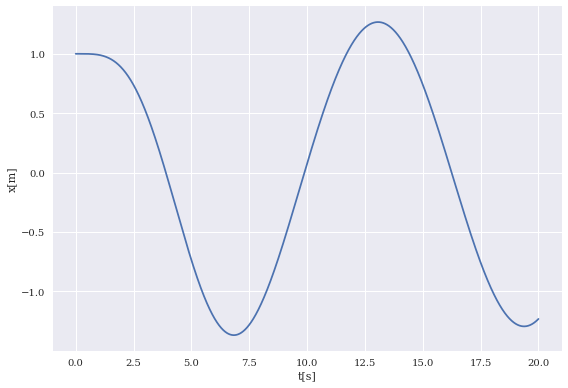

In [9]:
DeltaT = 0.001
#set up arrays 
tfinal = 20 # in dimensionless time
n = ceil(tfinal/DeltaT)
# set up arrays for t, v, and x
t = np.zeros(n)
v = np.zeros(n)
x = np.zeros(n)
# Initial conditions (can change to more than one dim)
x0 =  1.0 
v0 = 0.0
x[0] = x0
v[0] = v0
gamma = 0.2
Omegatilde = 0.5
Ftilde = 1.0
# Start integrating using the RK4 method
# Note that we define the force function as a SpringForce
RK4(v,x,t,n,SpringForce)

# Plot position as function of time    
fig, ax = plt.subplots()
ax.set_ylabel('x[m]')
ax.set_xlabel('t[s]')
ax.plot(t, x)
fig.tight_layout()
save_fig("ForcedBlockRK4")
plt.show()

## Example: The classical pendulum and scaling the equations

Let us end our discussion of oscillations with another classical case, the pendulum. You will find the material here useful for homework 7.

The angular equation of motion of the pendulum is given by
Newton's equation and with no external force it reads

<!-- Equation labels as ordinary links -->
<div id="_auto10"></div>

$$
\begin{equation}
  ml\frac{d^2\theta}{dt^2}+mgsin(\theta)=0,
\label{_auto10} \tag{10}
\end{equation}
$$

with an angular velocity and acceleration given by

<!-- Equation labels as ordinary links -->
<div id="_auto11"></div>

$$
\begin{equation}
     v=l\frac{d\theta}{dt},
\label{_auto11} \tag{11}
\end{equation}
$$

and

<!-- Equation labels as ordinary links -->
<div id="_auto12"></div>

$$
\begin{equation}
     a=l\frac{d^2\theta}{dt^2}.
\label{_auto12} \tag{12}
\end{equation}
$$

We do however expect that the motion will gradually come to an end due
a viscous drag torque acting on the pendulum.  In the presence of the
drag, the above equation becomes

<!-- Equation labels as ordinary links -->
<div id="eq:pend1"></div>

$$
\begin{equation}
   ml\frac{d^2\theta}{dt^2}+\nu\frac{d\theta}{dt}  +mgsin(\theta)=0, \label{eq:pend1} \tag{13}
\end{equation}
$$

where $\nu$ is now a positive constant parameterizing the viscosity
of the medium in question. In order to maintain the motion against
viscosity, it is necessary to add some external driving force. 
We choose here a periodic driving force. The last equation becomes then

<!-- Equation labels as ordinary links -->
<div id="eq:pend2"></div>

$$
\begin{equation}
   ml\frac{d^2\theta}{dt^2}+\nu\frac{d\theta}{dt}  +mgsin(\theta)=Asin(\omega t), \label{eq:pend2} \tag{14}
\end{equation}
$$

with $A$ and $\omega$ two constants representing the amplitude and 
the angular frequency respectively. The latter is called the driving frequency.

We define

$$
\omega_0=\sqrt{g/l},
$$

the so-called natural frequency and the new dimensionless quantities

$$
\hat{t}=\omega_0t,
$$

with the dimensionless driving frequency

$$
\hat{\omega}=\frac{\omega}{\omega_0},
$$

and introducing the quantity $Q$, called the *quality factor*,

$$
Q=\frac{mg}{\omega_0\nu},
$$

and the dimensionless amplitude

$$
\hat{A}=\frac{A}{mg}
$$

## More on the Pendulum

We have

$$
\frac{d^2\theta}{d\hat{t}^2}+\frac{1}{Q}\frac{d\theta}{d\hat{t}}  
     +sin(\theta)=\hat{A}cos(\hat{\omega}\hat{t}).
$$

This equation can in turn be recast in terms of two coupled first-order differential equations as follows

$$
\frac{d\theta}{d\hat{t}}=\hat{v},
$$

and

$$
\frac{d\hat{v}}{d\hat{t}}=-\frac{\hat{v}}{Q}-sin(\theta)+\hat{A}cos(\hat{\omega}\hat{t}).
$$

These are the equations to be solved.  The factor $Q$ represents the
number of oscillations of the undriven system that must occur before
its energy is significantly reduced due to the viscous drag. The
amplitude $\hat{A}$ is measured in units of the maximum possible
gravitational torque while $\hat{\omega}$ is the angular frequency of
the external torque measured in units of the pendulum's natural
frequency.

## The Pendulum code

We need to define a new force, which we simply call the pendulum
force. The only thing which changes from our previous spring-force
problem is the non-linearity introduced by angle $\theta$ due to the
$\sin{\theta}$ term.  Here we have kept a generic variable $x$
instead. This makes our codes very similar.  Feel free to use these examples for homework seven.

In [10]:
def PendulumForce(v,x,t):
#   note here that we have divided by mass and we return the acceleration
    return  -gamma*v-sin(x)+Ftilde*cos(t*Omegatilde)

## Setting up the various variables and running the code

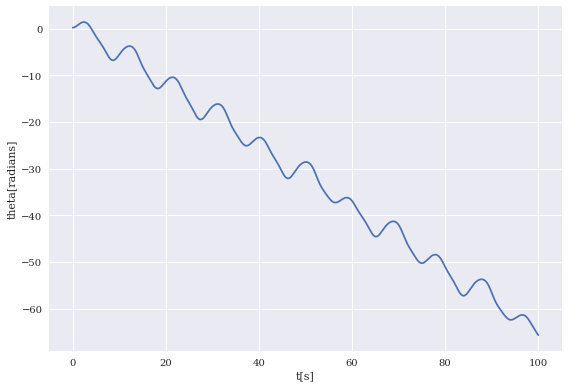

In [25]:
DeltaT = 0.001
#set up arrays 
tfinal = 100 # in years
n = ceil(tfinal/DeltaT)
# set up arrays for t, v, and x
t = np.zeros(n)
v = np.zeros(n)
theta = np.zeros(n)
# Initial conditions (can change to more than one dim)
theta0 =  0.2 
v0 = 0.0
theta[0] = theta0
v[0] = v0
gamma = 0.5
Omegatilde = 2./3.0
Ftilde = 1.465
# Start integrating using the RK4 method
# Note that we define the force function as a PendulumForce
RK4(v,theta,t,n,PendulumForce)

# Plot position as function of time    
fig, ax = plt.subplots()
ax.set_ylabel('theta[radians]')
ax.set_xlabel('t[s]')
ax.plot(t, theta)
fig.tight_layout()
save_fig("PendulumRK4")
plt.show()

## Principle of Superposition and Periodic Forces (Fourier Transforms)

If one has several driving forces, $F(t)=\sum_n F_n(t)$, one can find
the particular solution to each $F_n$, $x_{pn}(t)$, and the particular
solution for the entire driving force is

<!-- Equation labels as ordinary links -->
<div id="_auto13"></div>

$$
\begin{equation}
x_p(t)=\sum_nx_{pn}(t).
\label{_auto13} \tag{15}
\end{equation}
$$

This is known as the principal of superposition. It only applies when
the homogenous equation is linear. If there were an anharmonic term
such as $x^3$ in the homogenous equation, then when one summed various
solutions, $x=(\sum_n x_n)^2$, one would get cross
terms. Superposition is especially useful when $F(t)$ can be written
as a sum of sinusoidal terms, because the solutions for each
sinusoidal (sine or cosine)  term is analytic, as we saw above.

Driving forces are often periodic, even when they are not
sinusoidal. Periodicity implies that for some time $\tau$

$$
\begin{eqnarray}
F(t+\tau)=F(t). 
\end{eqnarray}
$$

One example of a non-sinusoidal periodic force is a square wave. Many
components in electric circuits are non-linear, e.g. diodes, which
makes many wave forms non-sinusoidal even when the circuits are being
driven by purely sinusoidal sources.

The code here shows a typical example of such a square wave generated using the functionality included in the **scipy** Python package. We have used a period of $\tau=0.2$.

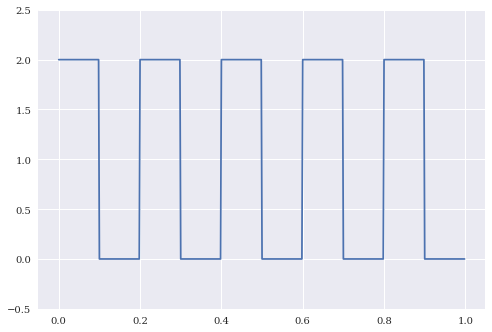

In [29]:
import numpy as np
import math
from scipy import signal
import matplotlib.pyplot as plt

# number of points                                                                                       
n = 500
# start and final times                                                                                  
t0 = 0.0
tn = 1.0
# Period                                                                                                 
t = np.linspace(t0, tn, n, endpoint=False)
SqrSignal = np.zeros(n)
SqrSignal = 1.0+signal.square(2*np.pi*5*t)
plt.plot(t, SqrSignal)
plt.ylim(-0.5, 2.5)
plt.show()

For the sinusoidal example studied in the previous week the
period is $\tau=2\pi/\omega$. However, higher harmonics can also
satisfy the periodicity requirement. In general, any force that
satisfies the periodicity requirement can be expressed as a sum over
harmonics,

<!-- Equation labels as ordinary links -->
<div id="_auto14"></div>

$$
\begin{equation}
F(t)=\frac{f_0}{2}+\sum_{n>0} f_n\cos(2n\pi t/\tau)+g_n\sin(2n\pi t/\tau).
\label{_auto14} \tag{16}
\end{equation}
$$

We can write down the answer for
$x_{pn}(t)$, by substituting $f_n/m$ or $g_n/m$ for $F_0/m$. By
writing each factor $2n\pi t/\tau$ as $n\omega t$, with $\omega\equiv
2\pi/\tau$,

<!-- Equation labels as ordinary links -->
<div id="eq:fourierdef1"></div>

$$
\begin{equation}
\label{eq:fourierdef1} \tag{17}
F(t)=\frac{f_0}{2}+\sum_{n>0}f_n\cos(n\omega t)+g_n\sin(n\omega t).
\end{equation}
$$

The solutions for $x(t)$ then come from replacing $\omega$ with
$n\omega$ for each term in the particular solution,

$$
\begin{eqnarray}
x_p(t)&=&\frac{f_0}{2k}+\sum_{n>0} \alpha_n\cos(n\omega t-\delta_n)+\beta_n\sin(n\omega t-\delta_n),\\
\nonumber
\alpha_n&=&\frac{f_n/m}{\sqrt{((n\omega)^2-\omega_0^2)+4\beta^2n^2\omega^2}},\\
\nonumber
\beta_n&=&\frac{g_n/m}{\sqrt{((n\omega)^2-\omega_0^2)+4\beta^2n^2\omega^2}},\\
\nonumber
\delta_n&=&\tan^{-1}\left(\frac{2\beta n\omega}{\omega_0^2-n^2\omega^2}\right).
\end{eqnarray}
$$

Because the forces have been applied for a long time, any non-zero
damping eliminates the homogenous parts of the solution, so one need
only consider the particular solution for each $n$.

The problem will considered solved if one can find expressions for the
coefficients $f_n$ and $g_n$, even though the solutions are expressed
as an infinite sum. The coefficients can be extracted from the
function $F(t)$ by

<!-- Equation labels as ordinary links -->
<div id="eq:fourierdef2"></div>

$$
\begin{eqnarray}
\label{eq:fourierdef2} \tag{18}
f_n&=&\frac{2}{\tau}\int_{-\tau/2}^{\tau/2} dt~F(t)\cos(2n\pi t/\tau),\\
\nonumber
g_n&=&\frac{2}{\tau}\int_{-\tau/2}^{\tau/2} dt~F(t)\sin(2n\pi t/\tau).
\end{eqnarray}
$$

To check the consistency of these expressions and to verify
Eq. ([18](#eq:fourierdef2)), one can insert the expansion of $F(t)$ in
Eq. ([17](#eq:fourierdef1)) into the expression for the coefficients in
Eq. ([18](#eq:fourierdef2)) and see whether

$$
\begin{eqnarray}
f_n&=?&\frac{2}{\tau}\int_{-\tau/2}^{\tau/2} dt~\left\{
\frac{f_0}{2}+\sum_{m>0}f_m\cos(m\omega t)+g_m\sin(m\omega t)
\right\}\cos(n\omega t).
\end{eqnarray}
$$

Immediately, one can throw away all the terms with $g_m$ because they
convolute an even and an odd function. The term with $f_0/2$
disappears because $\cos(n\omega t)$ is equally positive and negative
over the interval and will integrate to zero. For all the terms
$f_m\cos(m\omega t)$ appearing in the sum, one can use angle addition
formulas to see that $\cos(m\omega t)\cos(n\omega
t)=(1/2)(\cos[(m+n)\omega t]+\cos[(m-n)\omega t]$. This will integrate
to zero unless $m=n$. In that case the $m=n$ term gives

<!-- Equation labels as ordinary links -->
<div id="_auto15"></div>

$$
\begin{equation}
\int_{-\tau/2}^{\tau/2}dt~\cos^2(m\omega t)=\frac{\tau}{2},
\label{_auto15} \tag{19}
\end{equation}
$$

and

$$
\begin{eqnarray}
f_n&=?&\frac{2}{\tau}\int_{-\tau/2}^{\tau/2} dt~f_n/2\\
\nonumber
&=&f_n~\checkmark.
\end{eqnarray}
$$

The same method can be used to check for the consistency of $g_n$.

Consider the driving force:

<!-- Equation labels as ordinary links -->
<div id="_auto16"></div>

$$
\begin{equation}
F(t)=At/\tau,~~-\tau/2<t<\tau/2,~~~F(t+\tau)=F(t).
\label{_auto16} \tag{20}
\end{equation}
$$

Find the Fourier coefficients $f_n$ and $g_n$ for all $n$ using Eq. ([18](#eq:fourierdef2)).

Only the odd coefficients enter by symmetry, i.e. $f_n=0$. One can find $g_n$ integrating by parts,

<!-- Equation labels as ordinary links -->
<div id="eq:fouriersolution"></div>

$$
\begin{eqnarray}
\label{eq:fouriersolution} \tag{21}
g_n&=&\frac{2}{\tau}\int_{-\tau/2}^{\tau/2}dt~\sin(n\omega t) \frac{At}{\tau}\\
\nonumber
u&=&t,~dv=\sin(n\omega t)dt,~v=-\cos(n\omega t)/(n\omega),\\
\nonumber
g_n&=&\frac{-2A}{n\omega \tau^2}\int_{-\tau/2}^{\tau/2}dt~\cos(n\omega t)
+\left.2A\frac{-t\cos(n\omega t)}{n\omega\tau^2}\right|_{-\tau/2}^{\tau/2}.
\end{eqnarray}
$$

The first term is zero because $\cos(n\omega t)$ will be equally
positive and negative over the interval. Using the fact that
$\omega\tau=2\pi$,

$$
\begin{eqnarray}
g_n&=&-\frac{2A}{2n\pi}\cos(n\omega\tau/2)\\
\nonumber
&=&-\frac{A}{n\pi}\cos(n\pi)\\
\nonumber
&=&\frac{A}{n\pi}(-1)^{n+1}.
\end{eqnarray}
$$

## Fourier Series

More text will come here, chpater 5.7-5.8 of Taylor are discussed
during the lectures. The code here uses the Fourier series discussed
in chapter 5.7 for a square wave signal. The equations for the
coefficients are are discussed in Taylor section 5.7, see Example
5.4. The code here visualizes the various approximations given by
Fourier series compared with a square wave with period $T=0.2$, witth
$0.1$ and max value $F=2$. We see that when we increase the number of
components in the Fourier series, the Fourier series approximation gets closes and closes to the square wave signal.

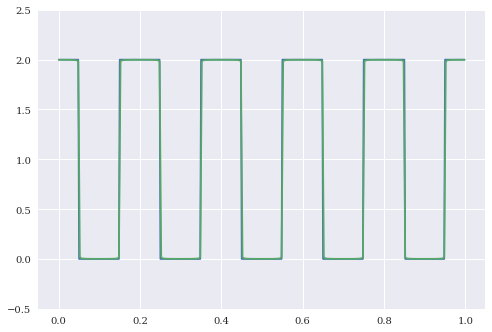

In [27]:
import numpy as np
import math
from scipy import signal
import matplotlib.pyplot as plt

# number of points                                                                                       
n = 500
# start and final times                                                                                  
t0 = 0.0
tn = 1.0
# Period                                                                                                 
T =0.2
# Max value of square signal                                                                             
Fmax= 2.0
# Width of signal                                                                                        
Width = 0.1
t = np.linspace(t0, tn, n, endpoint=False)
SqrSignal = np.zeros(n)
FourierSeriesSignal = np.zeros(n)
SqrSignal = 1.0+signal.square(2*np.pi*5*t+np.pi*Width/T)
a0 = Fmax*Width/T
FourierSeriesSignal = a0
Factor = 2.0*Fmax/np.pi
for i in range(1,500):
    FourierSeriesSignal += Factor/(i)*np.sin(np.pi*i*Width/T)*np.cos(i*t*2*np.pi/T)
plt.plot(t, SqrSignal)
plt.plot(t, FourierSeriesSignal)
plt.ylim(-0.5, 2.5)
plt.show()

## Response to Transient Force

Consider a particle at rest in the bottom of an underdamped harmonic
oscillator, that then feels a sudden impulse, or change in momentum,
$I=F\Delta t$ at $t=0$. This increases the velocity immediately by an
amount $v_0=I/m$ while not changing the position. One can then solve
the trajectory by solving the equations with initial
conditions $v_0=I/m$ and $x_0=0$. This gives

<!-- Equation labels as ordinary links -->
<div id="_auto17"></div>

$$
\begin{equation}
x(t)=\frac{I}{m\omega'}e^{-\beta t}\sin\omega't, ~~t>0.
\label{_auto17} \tag{22}
\end{equation}
$$

Here, $\omega'=\sqrt{\omega_0^2-\beta^2}$. For an impulse $I_i$ that
occurs at time $t_i$ the trajectory would be

<!-- Equation labels as ordinary links -->
<div id="_auto18"></div>

$$
\begin{equation}
x(t)=\frac{I_i}{m\omega'}e^{-\beta (t-t_i)}\sin[\omega'(t-t_i)] \Theta(t-t_i),
\label{_auto18} \tag{23}
\end{equation}
$$

where $\Theta(t-t_i)$ is a step function, i.e. $\Theta(x)$ is zero for
$x<0$ and unity for $x>0$. If there were several impulses linear
superposition tells us that we can sum over each contribution,

<!-- Equation labels as ordinary links -->
<div id="_auto19"></div>

$$
\begin{equation}
x(t)=\sum_i\frac{I_i}{m\omega'}e^{-\beta(t-t_i)}\sin[\omega'(t-t_i)]\Theta(t-t_i)
\label{_auto19} \tag{24}
\end{equation}
$$

Now one can consider a series of impulses at times separated by
$\Delta t$, where each impulse is given by $F_i\Delta t$. The sum
above now becomes an integral,

<!-- Equation labels as ordinary links -->
<div id="eq:Greeny"></div>

$$
\begin{eqnarray}\label{eq:Greeny} \tag{25}
x(t)&=&\int_{-\infty}^\infty dt'~F(t')\frac{e^{-\beta(t-t')}\sin[\omega'(t-t')]}{m\omega'}\Theta(t-t')\\
\nonumber
&=&\int_{-\infty}^\infty dt'~F(t')G(t-t'),\\
\nonumber
G(\Delta t)&=&\frac{e^{-\beta\Delta t}\sin[\omega' \Delta t]}{m\omega'}\Theta(\Delta t)
\end{eqnarray}
$$

The quantity
$e^{-\beta(t-t')}\sin[\omega'(t-t')]/m\omega'\Theta(t-t')$ is called a
Green's function, $G(t-t')$. It describes the response at $t$ due to a
force applied at a time $t'$, and is a function of $t-t'$. The step
function ensures that the response does not occur before the force is
applied. One should remember that the form for $G$ would change if the
oscillator were either critically- or over-damped.

When performing the integral in Eq. ([25](#eq:Greeny)) one can use
angle addition formulas to factor out the part with the $t'$
dependence in the integrand,

<!-- Equation labels as ordinary links -->
<div id="eq:Greeny2"></div>

$$
\begin{eqnarray}
\label{eq:Greeny2} \tag{26}
x(t)&=&\frac{1}{m\omega'}e^{-\beta t}\left[I_c(t)\sin(\omega't)-I_s(t)\cos(\omega't)\right],\\
\nonumber
I_c(t)&\equiv&\int_{-\infty}^t dt'~F(t')e^{\beta t'}\cos(\omega't'),\\
\nonumber
I_s(t)&\equiv&\int_{-\infty}^t dt'~F(t')e^{\beta t'}\sin(\omega't').
\end{eqnarray}
$$

If the time $t$ is beyond any time at which the force acts,
$F(t'>t)=0$, the coefficients $I_c$ and $I_s$ become independent of
$t$.

Consider an undamped oscillator ($\beta\rightarrow 0$), with
characteristic frequency $\omega_0$ and mass $m$, that is at rest
until it feels a force described by a Gaussian form,

$$
\begin{eqnarray*}
F(t)&=&F_0 \exp\left\{\frac{-t^2}{2\tau^2}\right\}.
\end{eqnarray*}
$$

For large times ($t>>\tau$), where the force has died off, find
$x(t)$.\\ Solve for the coefficients $I_c$ and $I_s$ in
Eq. ([26](#eq:Greeny2)). Because the Gaussian is an even function,
$I_s=0$, and one need only solve for $I_c$,

$$
\begin{eqnarray*}
I_c&=&F_0\int_{-\infty}^\infty dt'~e^{-t^{\prime 2}/(2\tau^2)}\cos(\omega_0 t')\\
&=&\Re F_0 \int_{-\infty}^\infty dt'~e^{-t^{\prime 2}/(2\tau^2)}e^{i\omega_0 t'}\\
&=&\Re F_0 \int_{-\infty}^\infty dt'~e^{-(t'-i\omega_0\tau^2)^2/(2\tau^2)}e^{-\omega_0^2\tau^2/2}\\
&=&F_0\tau \sqrt{2\pi} e^{-\omega_0^2\tau^2/2}.
\end{eqnarray*}
$$

The third step involved completing the square, and the final step used the fact that the integral

$$
\begin{eqnarray*}
\int_{-\infty}^\infty dx~e^{-x^2/2}&=&\sqrt{2\pi}.
\end{eqnarray*}
$$

To see that this integral is true, consider the square of the integral, which you can change to polar coordinates,

$$
\begin{eqnarray*}
I&=&\int_{-\infty}^\infty dx~e^{-x^2/2}\\
I^2&=&\int_{-\infty}^\infty dxdy~e^{-(x^2+y^2)/2}\\
&=&2\pi\int_0^\infty rdr~e^{-r^2/2}\\
&=&2\pi.
\end{eqnarray*}
$$

Finally, the expression for $x$ from Eq. ([26](#eq:Greeny2)) is

$$
\begin{eqnarray*}
x(t>>\tau)&=&\frac{F_0\tau}{m\omega_0} \sqrt{2\pi} e^{-\omega_0^2\tau^2/2}\sin(\omega_0t).
\end{eqnarray*}
$$